#Feature Ablation

This Jupyter Notebook is demonstrating how to use the captum library to perform feature ablation on an image using a pre-trained VGG16 model in PyTorch. Feature ablation is a technique used to determine the importance of different parts of an input with respect to the model's output. The attribution scores obtained from feature ablation can be visualized using the captum.attr.visualization module.

The first part of the code imports necessary libraries, loads and modifies the pre-trained VGG16 model, and defines the image transformation. Then, the input image is loaded and preprocessed using the defined transformation, and feature ablation is performed on the input image using the initialized FeatureAblation object.

The second part of the code reshapes and normalizes the computed feature attribution values, and then visualizes the heatmap of the attributions using the captum.attr.visualization module. The visualization is created using the heat_map method and the resulting heatmap is displayed using Matplotlib's imshow and plt.show methods. The title and colorbar are added to the visualization to provide additional information.

This Jupyter notebook is based on:

* https://captum.ai/tutorials/Resnet_TorchVision_Ablation
* https://captum.ai/docs/attribution_algorithms#feature-ablation
* http://arxiv.org/abs/1910.00174

#### Installing Captum Library

The following line installs version 0.6.0 of the Captum library.

This version is used because it is compatible with the other libraries used in this notebook.

In [1]:
!pip install matplotlib==3.6 captum==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


#### Configuring Matplotlib for Displaying Images

The following line configures Matplotlib to display images without padding.

This configuration is necessary because Matplotlib adds padding around images by default, which can affect the layout of the notebook. Setting the `bbox_inches` parameter to `None` removes the padding and ensures that images are displayed at their original size without any cropping or scaling.

In [1]:
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

#### Computing feature attribution using ablation method
A pre-trained VGG16 model is loaded and modified by replacing the input layer and output layer to adapt to the specific problem.

The image transformation is defined and the image is loaded and preprocessed using the defined transformation. Then, a FeatureAblation object is initialized and feature ablation is performed on the input image using this object.

Finally, the shape of the computed feature attribution is printed.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Import necessary libraries
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from captum.attr import FeatureAblation
import torch.nn.functional as F

# Check GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU.")

# Load the pre-trained VGG16 model with modified input layer
model = models.vgg16(pretrained=True)
model = model.to(device)  # Move the model to the GPU if available
model.eval()

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

image = Image.open('/content/drive/MyDrive/Colab Notebooks/images/school_bus.jpg')

transformed_img = transform(image)

input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0)
input_img = input_img.to(device)  # Move the input data to the GPU if available

target = torch.argmax(model(input_img))
print("Target class index:", target)

# Make predictions with the model
outputs = model(input_img)
output_probs = F.softmax(outputs, dim=1).squeeze(0)
# Find the index of the maximum value
label_idx = output_probs.argmax()
# Get the corresponding probability
probability = output_probs[label_idx].item() * 100 # converting to percentage
print(f"Label Index: {label_idx}, Probability: {probability:.2f}%")

# Define the baseline input
baseline = torch.zeros_like(input_img)
baseline = baseline.to(device)  # Move the baseline data to the GPU if available

# Initialize the FeatureAblation object
ablator = FeatureAblation(model)

# Compute the feature attribution using the ablation method
attributions = ablator.attribute(inputs=input_img, baselines=baseline)

print("Attributions shape:", attributions.shape)

GPU is available.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 240MB/s]


Target class index: tensor(779, device='cuda:0')
Label Index: 779, Probability: 100.00%
Attributions shape: torch.Size([1000, 3, 64, 85])


#### XAI metrics

A low infidelity value close to 0 indicates that the explanation provided by the XAI method is relatively faithful to the model's behavior. It suggests that the generated explanation is a good representation of how the model arrived at its predictions, making it a reliable and accurate explanation.

A Sensitivity value close to 1 indicates that the model is highly sensitive to changes in specific input features. In other words, small changes in those features can lead to substantial changes in the model's predictions. This suggests that the model heavily relies on the identified features to make its decisions.

In [4]:
from captum.metrics import infidelity, sensitivity_max
import numpy as np

# Assuming your original attributions tensor has the shape torch.Size([1000, 3, 64, 85])

# Calculate the mean along the batch dimension (axis 0) to get the averaged attributions
averaged_attributions = torch.mean(attributions, dim=0, keepdim=True)

# The shape of averaged_attributions will be torch.Size([1, 3, 64, 85])
print(averaged_attributions.shape)

# Define the perturbation function
def perturb_fn(inputs):
    # Multiplying by 0.003 scales the random values to control the magnitude of the perturbations.
    noise = torch.tensor(np.random.normal(0, 0.003, inputs.shape)).float().to(device)
    return noise.to(device), (inputs - noise).to(device)

# Compute the infidelity
infid = infidelity(model, perturb_fn, input_img, averaged_attributions, target=target)

print(f"Infidelity: {infid.item()}")

# Wrapper function for lr_lime.attribute
def fa_attr(inputs):
    return ablator.attribute(inputs)

# Calculate Sensitivity
sens = sensitivity_max(fa_attr, input_img)
print(f"Sensitivity: {sens.item()}")

torch.Size([1, 3, 64, 85])
Infidelity: 0.008332135155797005
Sensitivity: 9.667457580566406


#### Visualization
This cell is visualizing the feature attribution results obtained from the previous code block using the captum.attr.visualization module.

First, the computed feature attribution is reshaped to match the size of the input image, and then its absolute values are taken. The heatmap shape and the minimum and maximum values of the attributions are printed.

Next, the heatmap values are normalized to the range [0, 255] and converted to a numpy array of unsigned 8-bit integers. The original image is plotted first using Matplotlib's imshow method. Then, the heatmap of the attributions is visualized using the visualize_image_attr method from the captum.attr.visualization module. The visualization is shown using Matplotlib's plt.show() method.

The heat_map method is used to create the visualization with a color map specified as 'jet'. The 'all' sign is specified to show both positive and negative contributions. The title 'Feature Ablation' is also added to the visualization. The show_colorbar parameter is set to True to display a colorbar indicating the attribution values.

Heatmap shape: torch.Size([64, 85, 3])
Attributions min/max: tensor(1.1921e-07) tensor(0.4580)


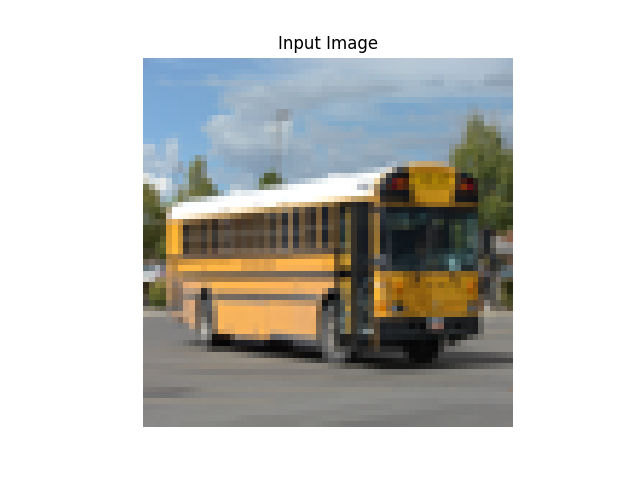

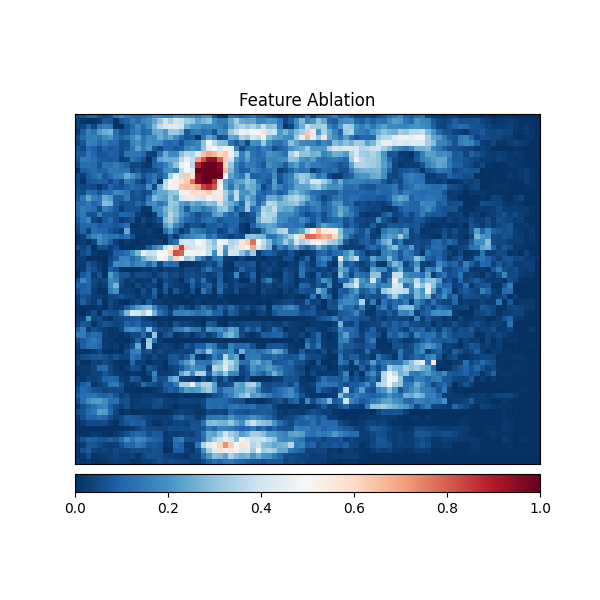

In [7]:
from torchvision import transforms
import matplotlib.colors as colors
from captum.attr import visualization as viz

# Reshape the attributions to match the image size
attributions = attributions.squeeze()
if len(attributions.shape) == 4:
    attributions = attributions[0]

attributions = attributions.to('cpu')
attributions = np.transpose(attributions, (1, 2, 0))
attributions = np.abs(attributions)

print("Heatmap shape:", attributions.shape)
print("Attributions min/max:", attributions.min(), attributions.max())

# Normalize the heatmap values to the range [0, 255]
attributions_norm = (attributions - attributions.min()) / (attributions.max() - attributions.min())
attributions_norm = (attributions_norm * 255).numpy().astype(np.uint8)

# Plot the heatmap of the attributions
plt.imshow(image.resize((64, 64)))
plt.axis('off')
plt.title('Input Image')
plt.show()

# Visualize the heatmap of the attributions
_ = viz.visualize_image_attr(attributions_norm,
                             method="heat_map",
                             cmap="RdBu_r",
                             show_colorbar=True,
                             title='Feature Ablation')

plt.show()
